In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
h = 0.00001
x = 3.0
#inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.00001
slope 0.9999999999621422


class Value:
    def __init__(self, data, _children = (), _op ='', label =''):
        self.data=data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._backwards = lambda : None
        self.label = label
        
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backwards():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backwards = _backwards
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backwards():
            self.grad += other.grad * out.grad
            other.grad += self.grad * out.grad
        out._backwards = _backwards
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other(int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
                    
        def _backwards():
            self.grad += other * (self.data ** (other -1)) * out.grad
            out._backward = _backward
    
    def __truediv__(self, other):
        return self * (other ** -1)
                    
    def __neg__(self):
                    return self * -1
    
    def __sub(self, other):
                    return self + (-other)
                    
    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Value(t, (self,), 'tanh')
        
        def _backwards():
            self.grad = (1 - t**2) * out.grad
        out._backwards = _backwards   
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backwards():
            self.grad += out.data * out.grad
            
        out.backward = _backward
    
    def _backwards(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backwards()

In [3]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
#inputs
x1 = Value(2.0, label ='x1')
x2 = Value(0.0, label ='x2')
#weights 
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label ='w2')
#bias
b = Value(6.8813735870195432, label ='b')
x1w1 = x1*w1 ;x1w1.label ='x1 * w1'
x2w2 = x2*w2 ;x2w2.label ='x2 * w2'
x1w1x2w2 =  x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

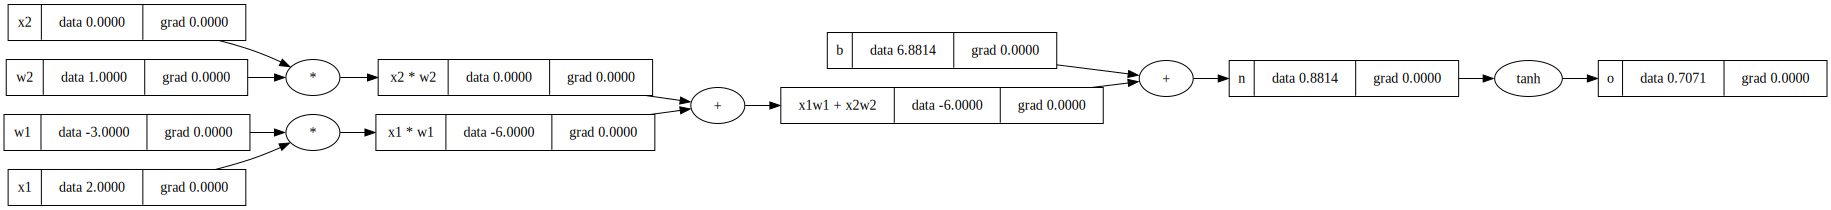

In [6]:
draw_dot(o)

In [7]:
# 1.32.13/ 2.25.51

In [8]:
import torch
import random

In [9]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]
        
    

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5815028993562126)

In [12]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

ys_tensor = torch.tensor(ys, dtype=torch.double)
ypred_tensor = torch.tensor([y.data for y in ypred], dtype=torch.double)
loss_tensor = torch.sum((ypred_tensor - ys_tensor) ** 2)

In [13]:
loss = sum([((yout - ygt) ** 2).data for ygt, yout in zip(ys, ypred)])
loss

2.5237092580218032

In [14]:
n.parameters()

[Value(data=-0.897483381519373),
 Value(data=0.8552899972471257),
 Value(data=0.977289063195695),
 Value(data=-0.9526621078211193),
 Value(data=-0.5245249434184183),
 Value(data=-0.8673653183903844),
 Value(data=-0.732118181602758),
 Value(data=0.20951172448915756),
 Value(data=-0.08675540761090983),
 Value(data=-0.4734096473575604),
 Value(data=-0.9546091007622934),
 Value(data=-0.9816660890011517),
 Value(data=-0.20961106229173398),
 Value(data=0.7364648131600837),
 Value(data=-0.8172828075588328),
 Value(data=0.5364839350084405),
 Value(data=0.8651248496178889),
 Value(data=-0.8822503638287791),
 Value(data=0.699910725753679),
 Value(data=-0.8615897272129247),
 Value(data=0.8234838621086924),
 Value(data=-0.18060654334374981),
 Value(data=-0.21238002637498798),
 Value(data=0.7017954374086384),
 Value(data=0.7455498547086947),
 Value(data=-0.9274057407215928),
 Value(data=-0.014402684681954492),
 Value(data=-0.8227816098029941),
 Value(data=-0.706484884719174),
 Value(data=-0.7380328

In [15]:
for k in range(20):
    
    #forwards
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backwards
    for p in n.parameters():
        p.grad = 0.0 
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 *p.grad
        
    print(k, loss.data)

0 2.5237092580218032
1 0.9536927519317403
2 0.47879986779185646
3 0.30741984770232994
4 0.2231159921495848
5 0.17313392622361073
6 0.14050795109934155
7 0.11772175108763015
8 0.10099641246923427
9 0.088244900827074
10 0.07822843434061065
11 0.07016873769577037
12 0.06355391706359012
13 0.0580343406177083
14 0.05336354437404358
15 0.049363070990469944
16 0.045900695020990485
17 0.042876467556673216
18 0.040213502264225064
19 0.03785173146074724


In [16]:
ypred


[Value(data=0.8961294897651931),
 Value(data=-0.8950103826478647),
 Value(data=-0.890634774768275),
 Value(data=0.9361323530840975)]